# **Lista 2** de Aprendizagem Automática

## **Assuntos:** Regressão Logística e Métodos Estatísticos

*   **Aluna:** Bárbara Neves
*   **Matrícula:** 507526

---



> <font color='blue'>**Jupyter notebook desenvolvido no Google Colab.**</font> Também pode ser acessado através do [link](https://github.com/barbaraneves/masters-machine-learning-course) no GitHub, sem alterações após o envio pelo SIGAA.



# Imports Principais

Neste notebook, utilizo apenas as bibliotecas presentes na célula abaixo, juntamente com alguns módulos da biblioteca **Scikit-learn**, **tqdm** e spicy.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Implementações

## Utils

<font color='red'>**Sobre o código:**</font> a seguir estão as funções auxiliares, utilitárias ou de suporte que são usadas para auxiliar na resolução das questões desta lista de exercícios.

In [ ]:
def plot_class_counts(data, width=6, height=5, palette='coolwarm'):
  # Set the figure size
  plt.figure(figsize=(width, height))

  # Plot count of occurrences for each class
  sns.countplot(data=data, palette=palette)
  plt.xlabel('Classes')
  plt.ylabel('Count')
  plt.show()

In [ ]:
def plot_gaussian_distribution(data):
  sns.distplot(data, kde=True, color='firebrick')
  
  plt.title("Distribuição de X")
  plt.xlabel('Valores')
  plt.ylabel('Densidade')
  plt.show()

In [ ]:
def plot_results(data, key='Global'):
  models = []
  accs = []
  stds = []

  for model, result in data.items():
    models.append(model)
    accs.append(result[key][0])
    stds.append(result[key][1])

  sns.set_style('whitegrid')
  fig, ax = plt.subplots(1, 2, figsize=(10, 6))

  data_accs = pd.DataFrame({'Model': models, 'Acc': accs})
  data_stds = pd.DataFrame({'Model': models, 'Stds': stds})

  if key == 'Global':
    sns.barplot(x='Model', y='Acc', data=data_accs, ax=ax[0], palette='coolwarm')
    sns.barplot(x='Model', y='Stds', data=data_stds, ax=ax[1], palette='coolwarm_r')

    ax0_title = 'Acurácia Global por Modelo'
    ax1_title = 'Desvio Padrão da Acuária Global por Modelo'
  elif key == 'Per Class':
    data_accs = data_accs.explode('Acc')
    data_accs['Classe'] = data_accs.groupby(level=0).cumcount()

    data_stds = data_stds.explode('Stds')
    data_stds['Classe'] = data_accs.groupby(level=0).cumcount()
    
    sns.barplot(x='Model', y='Acc', hue='Classe', data=data_accs, ax=ax[0], palette='coolwarm')
    sns.barplot(x='Model', y='Stds', hue='Classe', data=data_stds, ax=ax[1], palette='coolwarm_r')
    
    ax0_title = 'Acurácia por Classe e por Modelo'
    ax1_title = 'Desvio Padrão da Acurácia por Classe e por Modelo'

  ax[0].set_xticklabels(models, rotation=45)
  ax[0].set_xlabel('Modelo')
  ax[0].set_ylabel('Acurácia')
  ax[0].set_title(ax0_title)
  
  ax[1].set_xticklabels(models, rotation=45)
  ax[1].set_xlabel('Modelo')
  ax[1].set_ylabel('Desvio Padrão')
  ax[1].set_title(ax1_title)

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_data(X):
  scaler = StandardScaler()
  X_norm = scaler.fit_transform(X)
  X_norm = pd.DataFrame(X_norm, columns=X.columns)
  
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))
  sns.lineplot(data=X, ax=axs[0], legend=False, palette='coolwarm_r')
  axs[0].set_title('Antes da Normalização')
  sns.lineplot(data=X_norm, ax=axs[1], legend=False, palette='coolwarm')
  axs[1].set_title('Depois da Normalização')
  plt.show()
  
  return X_norm.values

In [ ]:
from os import access
def print_metric_results(results_dict):
  for model, metrics in results_dict.items():
    print(f"MODELO = {model}")
    print("  Métricas Globais:")
    print(f"    Acurácia = {metrics['Global'][0]}")
    print(f"    Desvio Padrão = {metrics['Global'][1]}")
    print("  Métricas por Classe:")

    accs = metrics['Per Class'][0]
    stds = metrics['Per Class'][1]

    for i in range(len(accs)):
      print(f"    Classe {i}")
      print(f"      Acurácia = {accs[i]}")
      print(f"      Desvio Padrão = {stds[i]}")
      if i < len(accs) - 1:
          print("      ------------------------")
    print("")

## Acurácias e K-fold Cross Validation

<font color='red'>**Sobre o código:**</font> o código apresentado possui duas funções principais.

- A primeira função é **`get_accuracy`**, que calcula a matriz de confusão com base em `y_real` e `y_pred`, e retorna a **acurácia global ou por classe** com base no valor de `result_type`.
- A segunda função é **`cross_val_kfold_score`**, que recebe como entrada as variáveis `X`, `y`, `n_splits` (número de folds para a validação cruzada), `model` (modelo de Aprendizado de Máquina a ser ajustado), e `seed`. Essa função realiza uma **validação cruzada k-fold** e retorna a acurácia global média e desvio padrão, bem como a acurácia por classe média e desvio padrão para cada fold (conforme solicitado nas alternativas b) de cada questão da lista).

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

def get_accuracy(y_real, y_pred, result_type='score'):
  if y_real.ndim == 2 and y_pred.ndim == 2:
    y_real = np.argmax(y_real, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
  
  cm = confusion_matrix(y_real, y_pred)

  if result_type == 'score':
    return cm.diagonal()/cm.sum(axis=0)
  elif result_type == 'report':
    return cm.diagonal()/cm.sum(axis=1)

def cross_val_kfold_score(X, y, n_splits, model, seed=42):
  global_scores = []
  report_scores = []

  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  
  for i, (train_index, test_index) in enumerate(tqdm(kfold.split(X), total=n_splits)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    global_scores.append(get_accuracy(y_test, y_pred).tolist())
    report_scores.append(get_accuracy(y_test, y_pred, result_type='report').tolist())

  final_scores = {
      'Global': [np.mean(global_scores), np.std(global_scores)],
      'Per Class': [np.mean(report_scores, axis=0).tolist(), np.std(report_scores, axis=0).tolist()]
  }
  
  return final_scores

## Regressão Logística

<font color='red'>**Sobre o código:**</font> a classe criada **`LogisticRegression`** e seus métodos fornecem docstrings autoexplicativas.

In [ ]:
class LogisticRegression():
  """
    Implementação do modelo de Regressão Logística com SGD
    para problemas de classificação binária ou multiclasse.

    Args:
        n_epochs (int): número de épocas para treinamento (default=100)
        alpha (float): taxa de aprendizado (default=0.01)
        activation (str): função de ativação usada para estimar as probabilidades da classe 
                          (default='sigmoid'). Opções válidas são 'sigmoid' para classificação binária
                          ou 'softmax' para classificação multiclasse.

    Atributos:
        w (array): matriz de pesos (coeficientes) aprendidos pelo modelo durante o treinamento.
        loss (list): histórico de perda em cada época de treinamento.

    Métodos públicos:
        fit(X, y): ajusta o modelo aos dados de treinamento X e y.
        predict(X): retorna as classes previstas para novos dados X.
        loss_history(): retorna uma lista do histórico de perda.

    Raises:
        ValueError: se `activation` não for uma função de ativação válida.
  """
  def __init__(self, n_epochs=100, alpha=0.01, activation='sigmoid'):
    self.n_epochs = n_epochs
    self.alpha = alpha    
    self.activation = activation

  def activation_function(self, z):
    """
      Retorna o valor da função de ativação aplicada a um determinado valor z.

      Args:
        z (ndarray): o valor de entrada.

      Returns:
        ndarray: o valor da função de ativação aplicada a z.
    """
    if self.activation == 'sigmoid':
      return 1 / (1 + np.exp(-z))
    elif self.activation == 'softmax':
      exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
      return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    else:
      raise ValueError('Função de ativação inválida')

  def loss_function(self, y_true, y_pred):
    """
      Calcula a função de perda para um conjunto de classes verdadeiras e preditas.

      Args:
        y_true (ndarray): o conjunto de classes verdadeiras.
        y_pred (ndarray): o conjunto de classes preditas.

      Returns:
        float: O valor da função de perda.
    """
    if self.activation == 'sigmoid':
      return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    elif self.activation == 'softmax':
      return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    else:
      raise ValueError('Função de ativação inválida')

  def fit(self, X, y):
    """
      Treina o modelo de Regressão Logística com SGD nos dados de entrada X e saídas y.

      Args:
        X (ndarray): dados de entrada com forma (n_samples, n_features).
        y (ndarray): vetor de claases correspondentes, com dimensão (n_samples,) para 'sigmoid' ou (n_samples, n_classes) para 'softmax'.

      Returns:
      None
    """
    loss = []
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    if self.activation == 'sigmoid':
      self.w = np.zeros((X.shape[1], 1))
    elif self.activation == 'softmax':
      self.w = np.zeros((X.shape[1], y.shape[1]))
    else:
      raise ValueError('Função de ativação inválida')

    for epoch in range(self.n_epochs):
      # Aplicando permutação nos dados
      perm = np.random.permutation(X.shape[0])
      X_shuffled = X[perm]
      y_shuffled = y[perm]

      for i in range(X.shape[0]):
        x_i = X_shuffled[i]
        y_i = y_shuffled[i]
        z = np.dot(x_i, self.w)

        if self.activation == 'sigmoid':
          y_pred = self.activation_function(z)
        elif self.activation == 'softmax':
          y_pred = self.activation_function(z.reshape(1, -1))
        else:
          raise ValueError('Função de ativação inválida')

        gradient = np.outer(x_i, (y_pred - y_i))
        self.w -= self.alpha * gradient
      
      y_pred_all = self.activation_function(np.dot(X_shuffled, self.w))
      loss.append(self.loss_function(y_shuffled, y_pred_all))
    self.loss = loss 

  def predict(self, X):
    """
      Realiza a predição das classes para os dados de entrada X.

      Args:
        X (ndarray): dados de entrada, em que cada linha é uma instância e cada coluna é um atributo.

      Returns 
        ndarray: matriz de predições, onde cada linha representa uma instância e cada coluna representa uma classe.
                Se a função de ativação for 'sigmoid', cada elemento é um valor binário (0 ou 1) indicando a classe predita. 
                Se a função de ativação for 'softmax', cada elemento é uma probabilidade que soma 1 em cada linha.
    """
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    y_pred = self.activation_function(np.dot(X, self.w))
    if self.activation == 'sigmoid':
      return (y_pred >= 0.5).astype(int)
    elif self.activation == 'softmax':
      y_pred = np.argmax(y_pred, axis=1)
      return np.eye(self.w.shape[1])[y_pred]
    else:
      raise ValueError('Função de ativação inválida')
                
  def loss_history(self):
    """
      Retorna o histórico de perda do treinamento do modelo.

      Returns:
        list: lista contendo os valores de perda para cada época do treinamento.
    """
    return self.loss

## Análise de Discriminante Gaussiano

<font color='red'>**Sobre o código:**</font> a classe criada **`GuassianDA`** e seus métodos fornecem docstrings autoexplicativas. Primeiro desenvolvi a próxima classe, `GaussianNB`, e realizei as seguintes mudanças para o `GaussianDA`.

- Alteração do cálculo da matriz de covariância para o cálculo de uma lista de matrizes de covariância, uma para cada classe.
- Alteração do cálculo da verossimilhança para o uso da função `multivariate_normal.logpdf` para cálculo do logaritmo da função de densidade de probabilidade multivariada.

In [ ]:
from scipy.stats import multivariate_normal

class GaussianDA():
  """
    Implementa o modelo estatístico Análise de Discriminante Gaussiano para problemas de classificação de dados assumindo uma distribuição Gaussiana.

    Atributos:
        classes (array): vetor unidimensional de todas as classes observadas no conjunto de treinamento.
        class_priors (array): vetor de probabilidade a priori de cada classe.
        class_means (array): matriz com as médias de cada feature para cada classe.
        class_covariances (array): lista com as matrizes de covariância para cada classe.

    Métodos:
        fit(X, y): estima os parâmetros do modelo a partir dos dados de treinamento.
        predict(X): prediz as classes correspondentes para cada amostra do conjunto X.

  """
  def __init__(self):
    self.classes = None
    self.class_priors = None
    self.class_means = None
    self.class_covariances = None

  def fit(self, X, y):
    """
      Estima os parâmetros do modelo a partir dos dados de treinamento.

      Args:
          X (array): dados de entrada com forma (n_samples, n_features).
          y (array): vetor de classes correspondentes, com dimensão (n_samples,).

      Returns:
          None
    """
    self.classes = np.unique(y)
    n_classes = len(self.classes)
    n_features = X.shape[1]

    self.class_priors = np.zeros(n_classes) # Proporção das classes
    self.class_means = np.zeros((n_classes, n_features))
    self.class_covariances = []

    for i, c in enumerate(self.classes):
      X_c = X[y == c]
      self.class_priors[i] = X_c.shape[0] / X.shape[0]
      self.class_means[i] = np.mean(X_c, axis=0)
      self.class_covariances.append(np.cov(X_c.T))

  def predict(self, X):
    """
      Realiza a predição das classes para os dados de entrada X.

      Args:
          X (array): dados de entrada, em que cada linha é uma instância e cada coluna é um atributo.

      Returns:
          (array): vetor com as classes preditas, com dimensão (n_samples,).
    """
    n_samples = X.shape[0]
    n_classes = len(self.classes)
    posterior_probs = np.zeros((n_samples, n_classes))

    for i, c in enumerate(self.classes):
      prior = np.log(self.class_priors[i])
      likelihood = multivariate_normal.logpdf(X, mean=self.class_means[i], cov=self.class_covariances[i])
      posterior_probs[:, i] = prior + likelihood

    return self.classes[np.argmax(posterior_probs, axis=1)]

## Naive Bayes Gaussiano

<font color='red'>**Sobre o código:**</font> a classe criada **`GuassianNB`** e seus métodos já fornecem docstrings autoexplicativas.

In [ ]:
from scipy.stats import norm

class GaussianNB():
  """
    Implementa o modelo estatístico Naive Bayes para problemas de classificação de dados assumindo uma distribuição Gaussiana.

    Atributos:
        classes (array): vetor unidimensional de todas as classes observadas no conjunto de treinamento.
        class_priors (array): vetor de probabilidade a priori de cada classe.
        class_means (array): matriz com as médias de cada feature para cada classe.
        class_variances (array): matriz com as variâncias de cada feature para cada classe.

    Métodos:
        fit(X, y): estima os parâmetros do modelo a partir dos dados de treinamento.
        predict(X): prediz as classes correspondentes para cada amostra do conjunto X.

  """
  def __init__(self):
    self.classes = None
    self.class_priors = None
    self.class_means = None
    self.class_variances = None

  def fit(self, X, y):
    """
      Estima os parâmetros do modelo a partir dos dados de treinamento.

      Args:
          X (array): dados de entrada com forma (n_samples, n_features).
          y (array): vetor de classes correspondentes, com dimensão (n_samples,).

      Returns:
          None
    """
    self.classes = np.unique(y)
    n_classes = len(self.classes)
    n_features = X.shape[1]

    self.class_priors = np.zeros(n_classes) # Proporção das classes
    self.class_means = np.zeros((n_classes, n_features))
    self.class_variances = np.zeros((n_classes, n_features)) #Variância
    
    for i, c in enumerate(self.classes):
      X_c = X[y == c]
      self.class_priors[i] = X_c.shape[0] / X.shape[0]
      self.class_means[i] = np.mean(X_c, axis=0)
      self.class_variances[i] = np.var(X_c, axis=0)

  def predict(self, X):
    """
      Realiza a predição das classes para os dados de entrada X.

      Args:
          X (array): dados de entrada, em que cada linha é uma instância e cada coluna é um atributo.

      Returns:
          (array): vetor com as classes preditas, com dimensão (n_samples,).
    """
    n_samples = X.shape[0]
    n_classes = len(self.classes)
    posterior_probs = np.zeros((n_samples, n_classes))
    
    for i, c in enumerate(self.classes):
      prior = np.log(self.class_priors[i])
      likelihood = np.sum(np.log(norm.pdf(X, self.class_means[i], np.sqrt(self.class_variances[i]))), axis=1)
      posterior_probs[:, i] = prior + likelihood
  
    return self.classes[np.argmax(posterior_probs, axis=1)]

# Questão 1

Considere o conjunto de dados disponível em `breastcancer.csv`, organizado
em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a
saída. 

Os 30 atributos coletados de exames médicos são usados no diagnóstico
do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa.

In [ ]:
df1 = pd.read_csv('breastcancer.csv', header=None)

df1.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1.0


In [ ]:
df1.describe()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [ ]:
df1.iloc[:, -1:].value_counts()

30 
0.0    357
1.0    212
dtype: int64

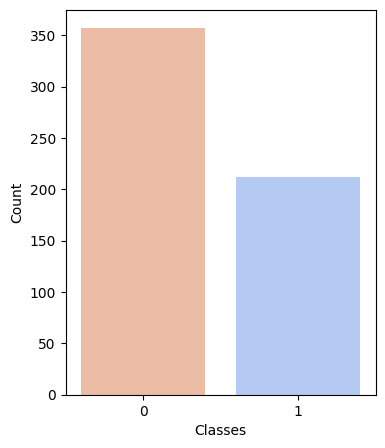

In [ ]:
class_data1 = [i*j for i, j in df1.iloc[:, -1:].value_counts().items()]

plot_class_counts(class_data1, width=4, height=5, palette='coolwarm_r')

In [ ]:
# 30 numeric, predictive attributes and the class
X1 = df1.iloc[:, :-1]
y1 = df1.iloc[:, -1:].values.ravel()

X1.shape, y1.shape

((569, 30), (569,))

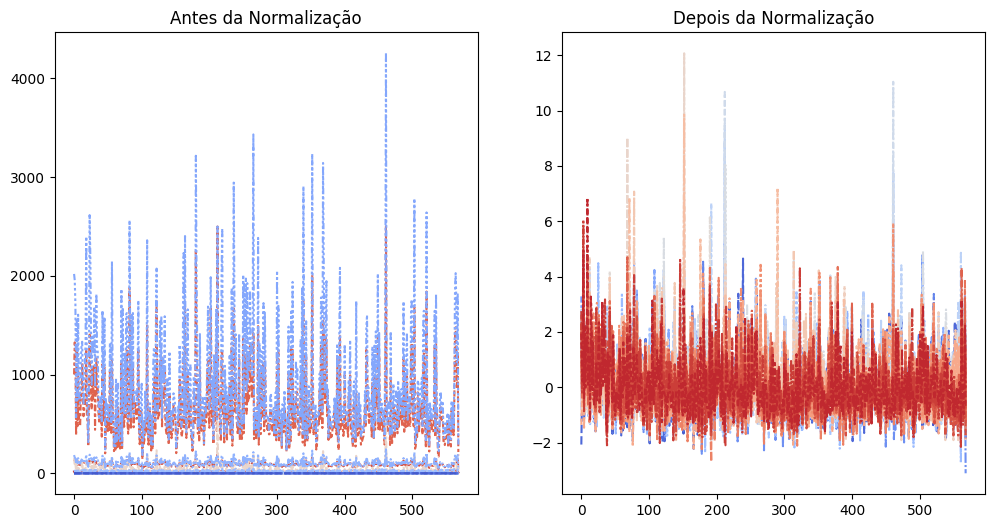

In [ ]:
X1_norm = normalize_data(X1)

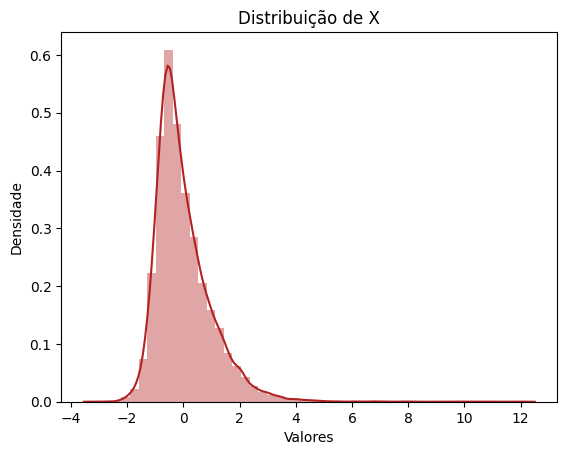

In [ ]:
plot_gaussian_distribution(data=X1_norm)

---

**Observações:**

> Os dados são desbalanceados, possuindo mais ocorrências para a classe negativa 0.

> Resolvi aplica uma **normalização** nos dados, não só porque alguns dos métodos solicitados na lista assumem distribuições Guassianas, mas principalmente por conta dos valores obtidos com o `df1.describe`. 

> Como os valores dos atributos não são similares/próximos entre si, ajustei a escala dos dados para um padrão comum, de modo a evitar que atributos com escalas maiores tenham maior peso na análise do modelo em detrimento dos com escalas menores. 

> Os plots dos gráficos acima ilustram o processo de normalização realizado para X. 

## Alternativas a) e b)

> **a)** Considerando uma validação cruzada em 10 *folds*, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens
abaixo:
> - **Regressão logística** (treinado com GD ou SGD);
> - **Análise do discriminante Gaussiano**;
> - **Naive Bayes Gaussiano**;

> **b)** Para cada modelo criado, reporte valor médio e desvio padrão da **acurácia global** e da **acurácia por classe**.

In [ ]:
models1 = {
    'LogisticRegression': LogisticRegression(activation='sigmoid'), 
    'GaussianDA': GaussianDA(),
    'GaussianNB': GaussianNB()
}

In [ ]:
# n_splits=10
results1 = {k: cross_val_kfold_score(X1_norm, y1, n_splits=10, model=model) for k, model in models1.items()}

100%|██████████| 10/10 [00:00<00:00, 81.75it/s]


In [ ]:
print_metric_results(results1)

MODELO = LogisticRegression
  Métricas Globais:
    Acurácia = 0.9725164444396519
    Desvio Padrão = 0.029474087424174077
  Métricas por Classe:
    Classe 0
      Acurácia = 0.9831796855788791
      Desvio Padrão = 0.013897114915823737
      ------------------------
    Classe 1
      Acurácia = 0.961604826546003
      Desvio Padrão = 0.044754556050855994

MODELO = GaussianDA
  Métricas Globais:
    Acurácia = 0.9529318357725867
    Desvio Padrão = 0.04546626477547423
  Métricas por Classe:
    Classe 0
      Acurácia = 0.9713413894663894
      Desvio Padrão = 0.02658024165842329
      ------------------------
    Classe 1
      Acurácia = 0.9430167941220571
      Desvio Padrão = 0.049359951210414185

MODELO = GaussianNB
  Métricas Globais:
    Acurácia = 0.9227522808547477
    Desvio Padrão = 0.06042883728332051
  Métricas por Classe:
    Classe 0
      Acurácia = 0.9515722453222452
      Desvio Padrão = 0.03959664059224108
      ------------------------
    Classe 1
      Acurácia 

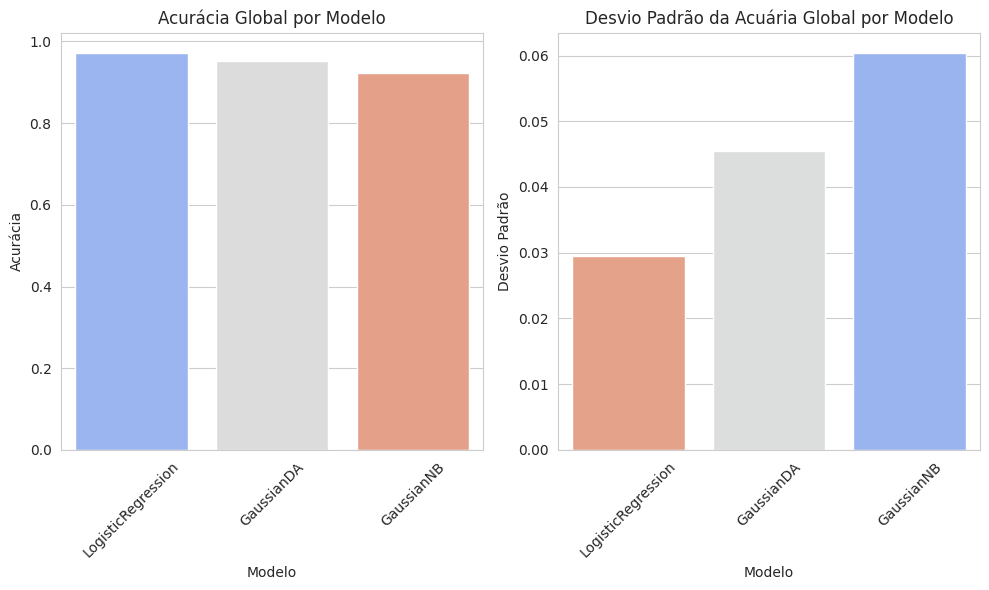

In [ ]:
plot_results(results1, key='Global')

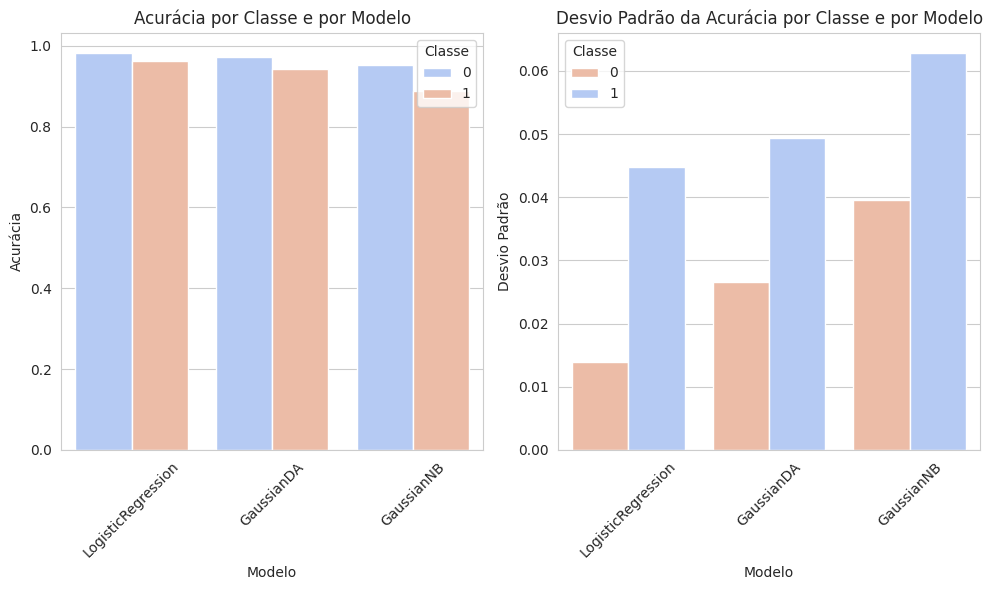

In [ ]:
plot_results(results1, key='Per Class')

---

**Observações:**

> Analisando a acurácia global, pode-se observar que o modelo de Regressão Logística obteve o melhor desempenho, com uma acurácia de 0.97, seguido por Análise de Discriminante Gaussiano com 0.95, e Naive Bayes Gaussiano com 0.92. 

> Já na análise por classe, o desempenho do modelo de Regressão Logística apresentou-se superior em ambas as classes, obtendo as acurácias de 0.98 para a classe negativa (0) e 0.96 para a classe positiva (1). Os demais modelos apresentaram desempenho inferior em ambas as classes.

> Além disso, o desvio padrão das acurácias global e por classe indica o quão variável é o desempenho do modelo ao longo das iterações do processo de validação. Nesse caso, todos os modelos apresentaram um desvio padrão relativamente baixo, o que sugere que seus desempenhos são consistentes ao longo das diferentes iterações do processo de validação.

> Em resumo, a análise dos resultados sugere que o modelo de Regressão Logística apresentou o melhor desempenho em relação aos demais modelos, tanto na análise global quanto por classe, com a vantagem adicional de apresentar menor variabilidade nos resultados obtidos. 

# Questão 2

Considere o conjunto de dados disponível em `vehicle.csv`, organizado em 19 co-
lunas, sendo as 18 primeiras colunas os atributos e a última coluna a saída. 

Os 18 atributos caracterizam a silhueta de veículos, extraídos pelo método HIPS (*Hierarchical Image Processing System*). A tarefa consiste em classificar o veículo em 4 classes (`bus`, `opel`, `saab`, e `van`).

In [ ]:
df2 = pd.read_csv('vehicle.csv', header=None)

df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,95.0,48.0,83.0,178.0,72.0,10.0,162.0,42.0,20.0,159.0,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197.0,3.0
1,91.0,41.0,84.0,141.0,57.0,9.0,149.0,45.0,19.0,143.0,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199.0,3.0
2,104.0,50.0,106.0,209.0,66.0,10.0,207.0,32.0,23.0,158.0,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196.0,2.0
3,93.0,41.0,82.0,159.0,63.0,9.0,144.0,46.0,19.0,143.0,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207.0,3.0
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,0.0


In [ ]:
df2.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.00000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,93.678487,44.861702,82.088652,168.940898,61.693853,8.567376,168.839243,40.933806,20.582742,147.998818,188.625296,439.911348,174.70331,72.462175,6.377069,12.599291,188.932624,195.632388,1.469267
std,8.234474,6.169866,15.771533,33.472183,7.888251,4.601217,33.244978,7.811560,2.592138,14.515652,31.394837,176.692614,32.54649,7.486974,4.918353,8.931240,6.163949,7.438797,1.111905
min,73.000000,33.000000,40.000000,104.000000,47.000000,2.000000,112.000000,26.000000,17.000000,118.000000,130.000000,184.000000,109.00000,59.000000,0.000000,0.000000,176.000000,181.000000,0.000000
25%,87.000000,40.000000,70.000000,141.000000,57.000000,7.000000,146.250000,33.000000,19.000000,137.000000,167.000000,318.250000,149.00000,67.000000,2.000000,5.000000,184.000000,190.250000,0.000000
50%,93.000000,44.000000,80.000000,167.000000,61.000000,8.000000,157.000000,43.000000,20.000000,146.000000,178.500000,364.000000,173.00000,71.500000,6.000000,11.000000,188.000000,197.000000,1.000000
75%,100.000000,49.000000,98.000000,195.000000,65.000000,10.000000,198.000000,46.000000,23.000000,159.000000,217.000000,587.000000,198.00000,75.000000,9.000000,19.000000,193.000000,201.000000,2.000000
max,119.000000,59.000000,112.000000,333.000000,138.000000,55.000000,265.000000,61.000000,29.000000,188.000000,320.000000,1018.000000,268.00000,135.000000,22.000000,41.000000,206.000000,211.000000,3.000000


In [ ]:
df2.iloc[:, -1:].value_counts()

18 
0.0    218
2.0    217
1.0    212
3.0    199
dtype: int64

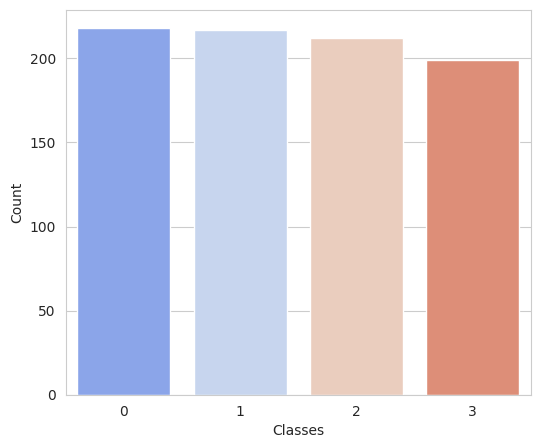

In [ ]:
class_data2 = [i*j for i, j in df2.iloc[:, -1:].value_counts().items()]

plot_class_counts(class_data2)

In [ ]:
X2 = df2.iloc[:, :-1]
y2 = df2.iloc[:, -1:].values.ravel()
# Codificação one-hot para y apenas para a Regressão Logísticas
y2_encoded = np.eye(np.unique(y2).shape[0])[y2.astype(int)]

X2.shape, y2.shape, y2_encoded.shape

((846, 18), (846,), (846, 4))

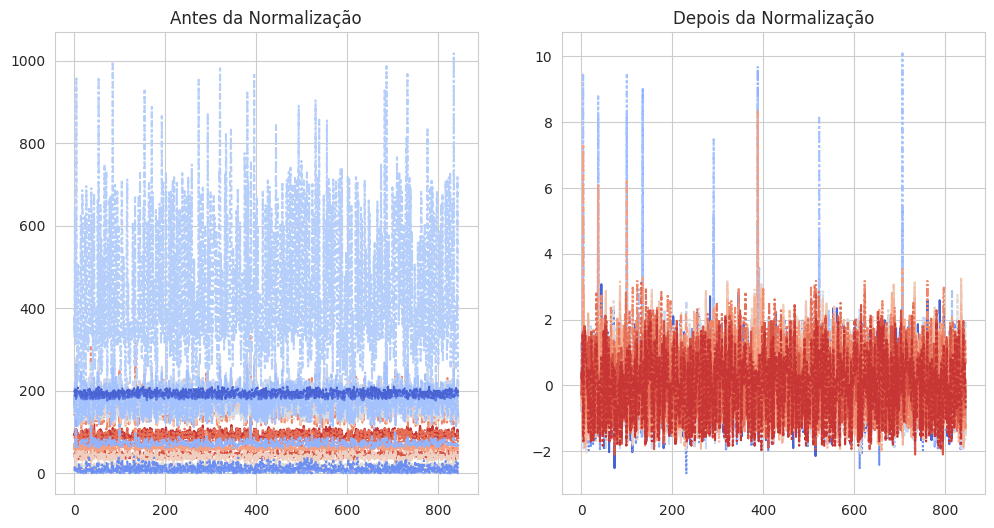

In [ ]:
X2_norm = normalize_data(X2)

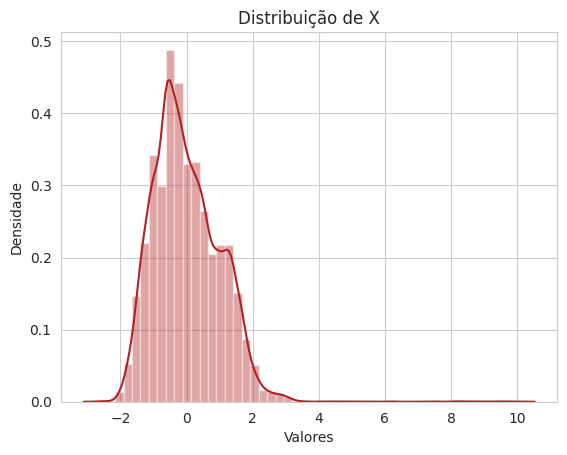

In [ ]:
plot_gaussian_distribution(data=X2_norm)

---

**Observações:**

> Os **dados** podem ser condiderados como **balanceados**.

> Da mesma forma como foi feito na Questão 1, os dados foram normalizados principalmente após a análise das estatísticas descritivas obtidas com o `df2.describe`.  

> Os plots dos gráficos acima ilustram o processo de normalização realizado para X. 

## Alternativas a) e b)

> **a)** Considerando uma validação cruzada em 10 *folds*, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens
abaixo:
> - **Regressão *softmax*** (treinado com GD ou SGD);
> - **Análise do discriminante Gaussiano**;
> - **Naive Bayes Gaussiano**;

> **b)** Para cada modelo criado, reporte valor médio e desvio padrão da **acurácia global** e da **acurácia por classe**.

In [ ]:
models2 = {
    'LogisticRegression': LogisticRegression(activation='softmax'), 
    'GaussianDA': GaussianDA(),
    'GaussianNB': GaussianNB()
}

In [ ]:
results2 = {k: cross_val_kfold_score(X2_norm, y2, n_splits=10, model=model) if k != 'LogisticRegression' else cross_val_kfold_score(X2_norm, y2_encoded, n_splits=10, model=model) for k, model in models2.items()}

100%|██████████| 10/10 [00:00<00:00, 324.71it/s]


In [ ]:
print_metric_results(results2)

MODELO = LogisticRegression
  Métricas Globais:
    Acurácia = 0.7956760952138877
    Desvio Padrão = 0.16690767758146643
  Métricas por Classe:
    Classe 0
      Acurácia = 0.9488294922087828
      Desvio Padrão = 0.03289473441458755
      ------------------------
    Classe 1
      Acurácia = 0.6217591973244146
      Desvio Padrão = 0.09254430583741928
      ------------------------
    Classe 2
      Acurácia = 0.63264130034725
      Desvio Padrão = 0.12298572697003689
      ------------------------
    Classe 3
      Acurácia = 0.9716803664172085
      Desvio Padrão = 0.037589907111106234

MODELO = GaussianDA
  Métricas Globais:
    Acurácia = 0.8522299383455971
    Desvio Padrão = 0.12357323722188743
  Métricas por Classe:
    Classe 0
      Acurácia = 0.9761261955054863
      Desvio Padrão = 0.024662740951183516
      ------------------------
    Classe 1
      Acurácia = 0.762257475900059
      Desvio Padrão = 0.10206951914835936
      ------------------------
    Classe 2
    

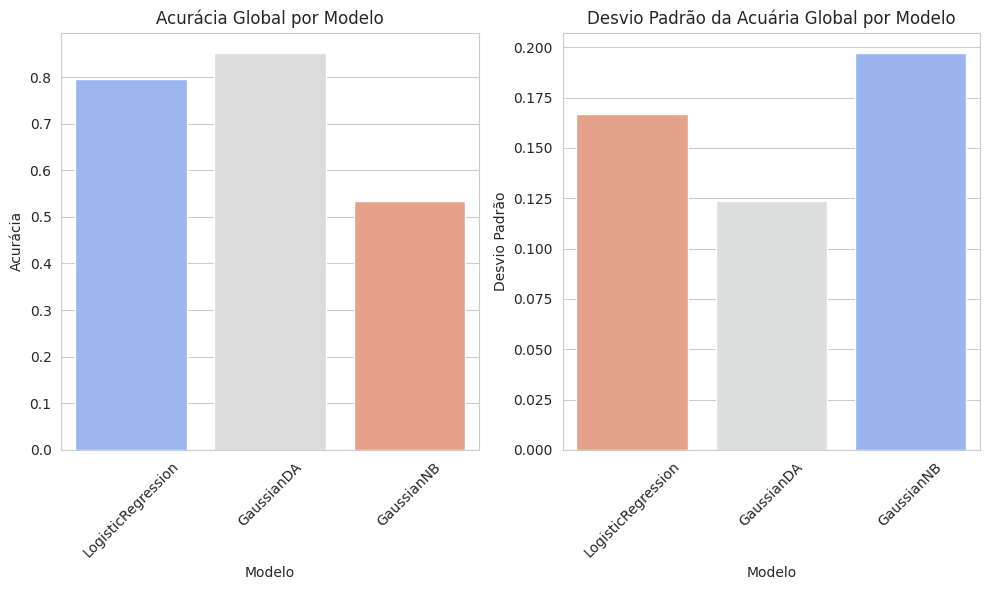

In [ ]:
plot_results(results2, key='Global')

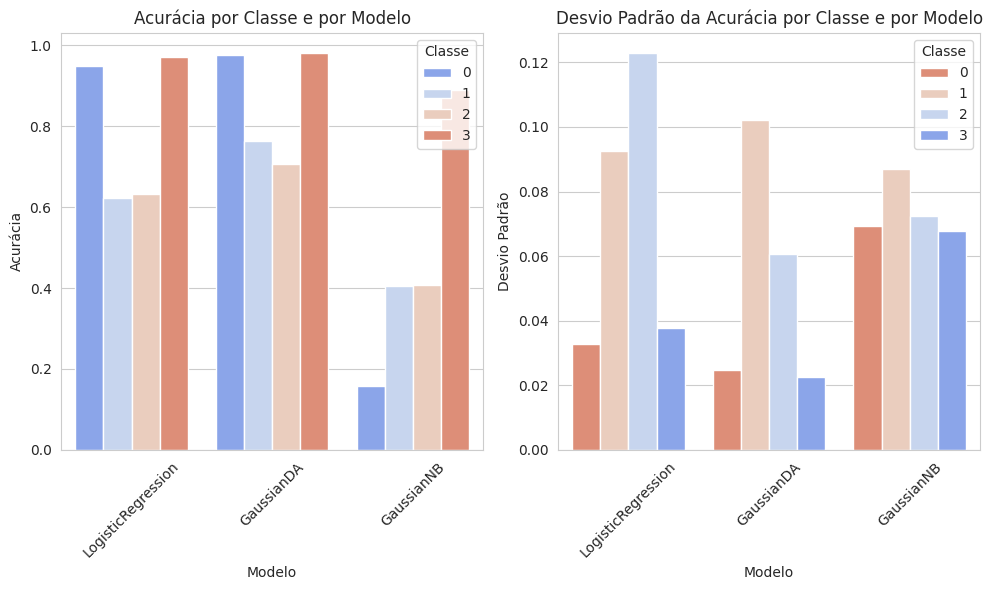

In [ ]:
plot_results(results2, key='Per Class')

--- 

**Observações:**

> A acurácia global é mais alta para o modelo de Análise de Discriminante Gaussiano (0.85), seguido pelo modelo de Regressão Logística (0.79) e pelo modelo Naive Bayes Guassiano (0.53). Isso sugere que, em geral, o modelo Análise de Discriminante Gaussiano teve um melhor desempenho na classificação dos dados de `vehicle.csv` em relação aos outros modelos.

> Entretanto, a análise por classe revela que o desempenho dos modelos varia consideravelmente, mesmo que os dados sejam balanceados. Além disso, os desvios padrão das acurácias por classe indicam que o desempenho dos modelos também varia consideravelmente entre as diferentes classes. 

> Por exemplo, o desvio padrão da acurácia do modelo de Regressão Logística é relativamente baixo para a classe 3 (~0.04), sugerindo que o modelo teve um bom desempenho consistente para essa classe. Já para a classe 2, o desvio padrão é mais alto (0.12), o que indica que o modelo teve um desempenho menos consistente para essa classe.

> Embora o `GaussianNB` e o `GaussianDA` sejam algoritmos baseados em modelos gaussianos e possam ser usados em conjuntos de dados com distribuição normal, suas abordagens e suposições são diferentes, por isso a diferença evidente entre as acurácias de cada modelo, se comparadas com a Questão 1.

> O `GaussianNB` é um classificador bayesiano ingênuo que faz suposições muito simples sobre a relação entre as variáveis de entrada e a classe de saída. Se a relação entre as variáveis de entrada e a classe de saída não é realmente independente ou se as distribuições não são normalmente distribuídas (o que é o caso do conjunto de dados), o modelo por ter desempenho inferior.

> Além disso, o `GaussianDA` é um modelo discriminativo, o que significa que ele aprende diretamente a fronteira de decisão entre as classes, enquanto o `GaussianNB` é um modelo generativo, o que significa que ele modela a distribuição conjunta de todas as variáveis de entrada e a classe de saída. 

> Em resumo, os resultados obtidos sugerem que o modelo de Análise de Discrminante Gaussiano teve um melhor desempenho geral na classificação dos dados, mas que o desempenho dos modelos varia consideravelmente entre as diferentes classes. 